In [1]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time
import glob

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('sg_article')
#plt.rcParams.update({"figure.figsize": (9,6)})
plt.rcParams.update({"text.usetex": True,})
plt.rcParams['legend.handlelength'] = 0

from AnalyseCID import AnalyseCID
from utils import *
from utils_plot import *

sys.path.append('ComputableInformationDensity_dev')
from ComputableInformationDensity_dev.cid import interlaced_time, cid2d
from ComputableInformationDensity_dev.computable_information_density import cid, cid_shuffle
from ComputableInformationDensity_dev.hilbert_curve import hilbert_curve, itter_hscan

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean, calc_weighted_mean_vec

In [4]:
base_path = f'Z:\\cid\\na'
save_path = f'data\\na'

extract = False
analyze = False
save_figs = True
verbose = True

data_suffix = 'ndg'  # 'sd', 'ndg' or ''    
use_seq = False

nbits = 6
#cg = 4
window_size=128
nframes=16

data_dict = {}

sd_data_dict = {
    'data_suffix': 'sd',
    'L_list': [512],
    'Nexp_list': [10],
    'cg': 4,
    'act_exclude_dict': {512: []},
    'xlims': None,
    'uncertainty_multiplier': 20,
    'act_critical': 0.022,
    'zero_fluc_point:': 1
}
zorder_data_dict = {
'data_suffix': '_zorder',
'L_list': [512],
'Nexp_list': [5],
'cg': 4,
'act_exclude_dict': {512: [0.02, 0.0235]},
'xlims': (0.016, 0.045),
'uncertainty_multiplier': 20,
'act_critical': 0.022,
'zero_fluc_point:': 1
}
s_data_dict = {
'data_suffix': 's',
'L_list': [2048],
'Nexp_list': [3],
'cg': 4,
'act_exclude_dict': {2048: []},
'xlims': None,
'uncertainty_multiplier': 1,
'act_critical': 2.1,
'zero_fluc_point:': 0
}
na_data_dict = {
    'data_suffix': '',
    'L_list': [512, 1024, 2048],
    'Nexp_list': [5]*3,
    'act_exclude_dict': {512: [0.02, 0.0225, 0.0235], 1024: [], 2048: [0.0225]},
    'xlims': (0.016, 0.045),
    'uncertainty_multiplier': 20,
    'act_critical': 0.022,
    'cg': 4,
    'zero_fluc_point:': 1
    }

na512_data_dict = {
    'data_suffix': '',
    'L_list': [512,],
    'Nexp_list': [5],
    'act_exclude_dict': {512: [0.02, 0.0225, 0.0235],},
    'xlims': (0.016, 0.045),
    'uncertainty_multiplier': 20,
    'act_critical': 0.022,
    'cg': 4,
    'zero_fluc_point:': 1
    }
na1024_data_dict = {
    'data_suffix': '',
    'L_list': [1024,],
    'Nexp_list': [5],
    'act_exclude_dict': {1024: [],},
    'xlims': (0.016, 0.045),
    'uncertainty_multiplier': 20,
    'act_critical': 0.022,
    'cg': 4,
    'zero_fluc_point:': 1
    }
na2048_data_dict = {
    'data_suffix': '',
    'L_list': [2048,],
    'Nexp_list': [5],
    'act_exclude_dict': {2048: [0.0225],},
    'xlims': (0.016, 0.045),
    'uncertainty_multiplier': 20,
    'act_critical': 0.022,
    'cg': 4,
    'zero_fluc_point:': 1
    }

abp_data_dict = {
        'data_suffix': 'abp',
        'L_list': [256],
        'Nexp_list': [1],
        'act_exclude_dict': {256: []},
        'xlims': None,
        'uncertainty_multiplier': 5,
        'act_critical': None,
        'cg': 1,
        'zero_fluc_point:': 0
    }

ndg_data_dict = {
    'data_suffix': 'ndg',
    'L_list': [1024],
    'Nexp_list': [1],
    'act_exclude_dict': {1024: []},
    'xlims': None,
    'uncertainty_multiplier': 20,
    'act_critical': 7,
    'cg': 2,
    'zero_fluc_point:': 0
}
pol_data_dict = {
    'data_suffix': 'pol',
    'L_list': [2048],
    'Nexp_list': [1],
    'act_exclude_dict': {2048: [0.05, 0.1, 0.105,0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14,]},
    'xlims': None,
    'uncertainty_multiplier': 5,
    'act_critical': None,
    'cg': 4,
    'zero_fluc_point:': 1
}

data_dict = {'sd': sd_data_dict, 'ndg': ndg_data_dict, 
             'na': na_data_dict, 'na512': na512_data_dict, 
             'na1024': na1024_data_dict, 'na2048': na2048_data_dict, 
             's': s_data_dict, '_zorder': zorder_data_dict, 'pol': pol_data_dict,
             'abp': abp_data_dict}
fig_folder_dict = {'sd': 'sd', 'ndg': 'ndg', 'na': 'na',
                'na512': 'na512',
                'na1024': 'na1024', 
                'na2048': 'na2048', 's': 's',
                'pol': 'pol',
                'abp': 'abp',}
cg = data_dict[data_suffix]['cg']

if window_size is not None:
        seq = False
        output_suffix_func = lambda size: f'_nx{window_size}nt{size}cg{cg}'
        output_suffix = output_suffix_func(nframes)
else:
    seq = use_seq
    output_suffix_func = lambda nbits: f'_seq_nb{nbits}cg{cg}' if seq else f'_nb{nbits}cg{cg}'
    output_suffix = output_suffix_func(nbits)


cid_dict = {
    'base_path': base_path,
    'save_path': save_path,
    'cg': cg,
    'verbose': verbose,
    'output_suffix': output_suffix,
    'ddof': 1,
    **data_dict[data_suffix]
}


#output_suffix = data_dict[data_suffix]['output_suffix']
fig_folder = fig_folder_dict[data_suffix]
figs_save_path = f'data\\figs\\{fig_folder}\\{output_suffix[1:]}'
if not os.path.exists(figs_save_path): 
    os.makedirs(figs_save_path)

ac = AnalyseCID(cid_dict, load_data=True)

# Set figure save path
ac.figs_save_path = figs_save_path

if extract:
    ac.run()
if analyze and not extract:
    ac.analyze()



In [5]:
def plot_thermodynamic_efficiency(L_list, act_dict, entropy_deriv_dict, order_param_dict, zero_response_val, \
                            shift_act = False, xlims=None, plot_abs=False, savepath=None):
    """
    Plot CID variance and derivative vs activity for different system sizes.

    Parameters:
    ----------
    L_list : list
        List of system sizes (e.g., [16, 32, 64, 128]).
    act_dict : dict
        Dictionary mapping system size to activity list.
    entropy_deriv_dict : dict
        Dictionary mapping system size to av. entropy derivative w.r.t. control param.
        Each value should be an array with shape (n-1, 2): [mean, sem].
    order_param_dict : dict
        Dictionary mapping system size to order parameter data.
        Each value should be an array with shape (n, 2): [mean, sem].
    zero_response_val : float
        Value of the order parameter at which the response is zero.
    xlims : list, default [0, None]
        x-axis limits for the plots.
    plot_abs : bool, default False
        Whether to plot the absolute value of the derivative.
    savepath : str, default None
        Path where the figure is saved if not None

    Returns:
    -------
    fig, ax : matplotlib.figure.Figure, matplotlib.axes.Axes
        The created figure and axes.
    """

    ncols = len(L_list)
    w = 4 * ncols
    #w += 1 if ncols < 3 else 0
    fig, ax0 = plt.subplots(ncols=ncols, figsize=(w,4))
    marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']
    
    if plot_abs:
        dylabel_per = r'$\vert \frac{d\textrm{CID}}{d\tilde{\zeta}}\vert/\vert\textrm{CID} \vert$'
        dylabel = r'$\vert d\textrm{CID}/d\tilde{\zeta}\vert$'
    else:
        dylabel_per = r'$\frac{d \textrm{CID}}{d\tilde{\zeta}}/\textrm{CID}$'
        dylabel = r'$\frac{d \textrm{CID}}{d\tilde{\zeta}}$'

    for i, LX in enumerate(L_list):
        ax = ax0 if ncols == 1 else ax0[i]

        act_list = act_dict[LX]
        order_para = order_param_dict[LX].copy()
        entropy_deriv = entropy_deriv_dict[LX].copy()
        if shift_act:
            act_list =  act_list[:-1] + np.diff(act_list) / 2
            order_para = 0.5 * (order_para[:-1] + order_para[1:])
        else:
            if len(entropy_deriv) < len(act_list):
                act_list =  act_list[:-1]
                order_para = order_para[:-1]
        thermo_eff = - entropy_deriv[:,0] / (zero_response_val - order_para[:,0])
        thermo_eff_sem = np.abs(thermo_eff) * np.sqrt( (entropy_deriv[:,1]/entropy_deriv[:,0])**2 + (order_para[:,1]/order_para[:,0])**2 )

        if plot_abs:
            thermo_eff = np.abs(thermo_eff)
            entropy_deriv[:,0] = np.abs(entropy_deriv[:,0])


        ax.errorbar(act_list, thermo_eff,yerr=thermo_eff_sem,
            fmt=marker_shape[1],
            lw=1, 
            elinewidth=1.5, alpha=0.6, label =r'$\eta_\textrm{eff}$')
        ax.errorbar(act_list, entropy_deriv[:,0], yerr=entropy_deriv[:,1],
            fmt=marker_shape[1],
            lw=1, 
            elinewidth=1.5, alpha=0.6, label =dylabel)
        
    ax = [ax0] if ncols == 1 else ax0
    for axx in ax:
        axx.set(xlabel=r'Activity ($\tilde{\zeta}$)')
        xlim = axx.get_xlim() if xlims is None else xlims
        axx.set_xlim(xlim)
        axx.set_ylim(axx.get_ylim())
        axx.hlines(0, xlim[0], xlim[1], colors='black', linestyles='solid', lw=1, alpha=0.8,zorder=-5)
        axx.legend()

    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, bbox_inches='tight', dpi=620, pad_inches=0.05)
        print(f"Figure saved to: {savepath}")
    return fig, ax

def plot_cid_scaling(LX, nbits_list, ac_list, cg=1, sequential=False, act_critical=None, use_min=False, xlims=None, errorbar=True,plot_abs=False, shift_act=False, savepath=None):
    """
    Plot CID and its derivative vs activity for window sizes in nbits_list.

    Parameters:
    ----------
    LX : int
        System size.
    nbits_list : list
        List of nbits values corresponding to different window sizes.
    ac_list : list
        List of AnalyseCID objects corresponding to each nbits in nbits_list.
    cg : int, default 1
        Coarse-graining factor.
    xlims : list, default [0, None]
        x-axis limits for the plots.
    savepath : str, default None
        Path where the figure is saved if not None
    Returns:
    -------
    fig, ax0 : matplotlib.figure.Figure, np.ndarray of Axes
        The created figure and axes array.
    """

    fig, ax0 = plt.subplots(ncols=2, figsize=(10, 4))
    marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']

    ax_cid, ax_dcid = ax0

    for i, nbits in enumerate(nbits_list):
        ac = ac_list[i]
        act_list = ac.act[LX]
        if use_min:
            cid_time_av = ac.cidm_tav[LX].copy()
            deriv_cid = ac.dcidm[LX].copy()
        else:
            cid_time_av = ac.cid_tav[LX].copy()
            deriv_cid = ac.dcid[LX].copy()

        Nderiv = deriv_cid.shape[0]
        act_diff_tot = act_list[:-1] + np.diff(act_list) / 2 if shift_act else act_list[:Nderiv]
        if plot_abs:
            deriv_cid[:, 0] = np.abs(deriv_cid[:, 0])

        size = int(2**nbits)
        window_label = rf'$L_t$$\times$$L_s^2$: {size}$\times${cg * size}$^2$' if not sequential else rf'$L_t$$\times$$L_s^2$: {1}$\times${cg * size}$^2$'

        if errorbar:
            ax_cid.errorbar(act_list,cid_time_av[:, 0],yerr=cid_time_av[:, 1],
                fmt=marker_shape[i % len(marker_shape)],
                lw=1,label=window_label,
                elinewidth=1.5, alpha=0.6)
            ax_dcid.errorbar(act_diff_tot,deriv_cid[:, 0],yerr=deriv_cid[:, 1],
                fmt=marker_shape[i % len(marker_shape)],
                lw=1, label=window_label,
                elinewidth=1.5, alpha=0.6)
        else:
            ax_cid.plot(act_list,cid_time_av[:, 0],
                '-', #marker_shape[i % len(marker_shape)],
                lw=2,label=window_label,
                alpha=0.6)
            ax_dcid.plot(act_diff_tot,deriv_cid[:, 0],
                '-', #marker_shape[i % len(marker_shape)],
                lw=2, label=window_label,
                alpha=0.6)

    for ax in ax0:
        ax.set(xlabel=r'Activity ($\tilde{\zeta}$)')
        xlim = ax.get_xlim() if xlims is None else xlims
        ylim = ax.get_ylim()
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.hlines(0, xlim[0], xlim[1], colors='black', linestyles='solid', lw=1, alpha=0.8,zorder=-5)
        if act_critical is not None:
            ax.vlines(act_critical, ylim[0], ylim[1], color='k', linestyle='--', zorder=-5, lw=1)

    if plot_abs:
        dy_label = r'$\vert d\textrm{CID}/d \tilde{\zeta} \vert$'
    else:
        dy_label = r'$d\textrm{CID}/d\tilde{\zeta}$'
        
    ax_cid.set_ylabel(r'$\textrm{CID}$')
    ax_dcid.set_ylabel(dy_label)
    ax_dcid.legend(fontsize=12)
   # ax_cid.legend()

    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, bbox_inches='tight', dpi=620, pad_inches=0.05)
        print(f"Figure saved to: {savepath}")
    return fig, ax0

def plot_div_scaling(LX, nbits_list, ac_list, cg=1,\
                        act_critical=None, xlims=None, use_min=False, sequential=False, plot_abs=False, errorbar=True, shift_act=False, savepath=None):
    """ 
    Plot Divergence and its derivative vs activity for different window sizes.
    
    Parameters:
    ----------
    LX : int
        System size.
    nbits_list : list
        List of nbits values corresponding to different window sizes.
    ac_list : list
        List of AnalyseCID objects corresponding to each nbits in nbits_list.
    cg : int, default 1
        Coarse-graining factor.
    xlims : list, default [0, None]
        x-axis limits for the plots.
    savepath : str, default None    
        Path where the figure is saved if not None

    Returns:
    --------
    fig, ax0 : matplotlib.figure.Figure, np.ndarray of Axes
        The created figure and axes array.
    """
    fig, ax0 = plt.subplots(ncols=2, figsize=(10, 4))
    marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']
    ax_div, ax_ddiv = ax0

    for i, nbits in enumerate(nbits_list):
        ac = ac_list[i]
        act_list = ac.act[LX]

        if use_min:
            div_time_av = ac.fracm_tav[LX].copy()
            deriv_div = ac.dfracm[LX].copy()
        else:
            div_time_av = ac.frac_tav[LX].copy()
            deriv_div = ac.dfrac[LX].copy()
        Nderiv = deriv_div.shape[0]
        act_diff_tot = act_list[:-1] + np.diff(act_list) / 2 if shift_act else act_list[:Nderiv]

        size = int(2**nbits)
        window_label = rf'$L_t$$\times$$L_s^2$: {size}$\times${cg * size}$^2$' if not sequential else rf'$L_t$$\times$$L_s^2$: {1}$\times${cg * size}$^2$'

        # Convert CID/CID_shuffle to Divergence
        div_time_av[:, 0] = 1 - div_time_av[:, 0]
        deriv_div[:, 0] *= -1
        if plot_abs:
            deriv_div[:, 0] = np.abs(deriv_div[:, 0])

        if errorbar:
            ax_div.errorbar(act_list,div_time_av[:, 0],yerr=div_time_av[:, 1],
                fmt=marker_shape[i % len(marker_shape)],
                lw=1,label=window_label,
                elinewidth=1.5, alpha=0.6)
            ax_ddiv.errorbar(act_diff_tot,deriv_div[:, 0],yerr=deriv_div[:, 1],
                fmt=marker_shape[i % len(marker_shape)],
                lw=1, label=window_label,
                elinewidth=1.5, alpha=0.6)
        else:
            ax_div.plot(act_list,div_time_av[:, 0],
                marker_shape[i % len(marker_shape)], #'-',
                lw=1,label=window_label,
                alpha=0.6)
            ax_ddiv.plot(act_diff_tot,deriv_div[:, 0],
                marker_shape[i % len(marker_shape)], #'-',
                lw=1, label=window_label,
                alpha=0.6)
        
    for ax in ax0:
        ax.set(xlabel=r'Activity ($\tilde{\zeta}$)')
        xlim = ax.get_xlim() if xlims is None else xlims
        ylim = ax.get_ylim()
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.hlines(0, xlim[0], xlim[1], colors='black', linestyles='solid', lw=1, alpha=0.8,zorder=-5)
        if act_critical is not None:
            ax.vlines(act_critical, ylim[0], ylim[1], color='k', linestyle='--', zorder=-5, lw=1)
    if plot_abs:
        dy_label = r'$\vert d\mathcal{D}/d \tilde{\zeta} \vert$'
    else:
        dy_label = r'$d\mathcal{D}/d\tilde{\zeta}$'
    ax_div.set_ylabel(r'$\mathcal{D}$')
    ax_ddiv.set_ylabel(dy_label)
    ax_ddiv.legend(fontsize=12)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, bbox_inches='tight', dpi=620, pad_inches=0.05)
        print(f"Figure saved to: {savepath}")
    return fig, ax0

def plot_cid_fluctuation_scaling(LX, nbits_list, ac_list, cg=1, axis=None, act_exclude=[],
                            act_critical=None, zero_fluctuation_point=0, use_min=False, plot_cid_per=True, plot_var_per=False,
                            shift_var_by_fluctuation=False, xlims=None, plot_abs=False, shift_act=False, savepath=None):
    """
    Plot CID variance and derivative vs activity for different window sizes.
    Parameters:
    ----------

    Returns:

    """

    ncols = len(nbits_list  )
    w = 4 * ncols
    #w += 1 if ncols < 3 else 0
    if axis is not None:
        ax0 = axis
    else:
        fig, ax0 = plt.subplots(ncols=ncols, figsize=(w,4))
    marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']
    
    if plot_abs:
        dylabel_per = r'$\vert \frac{d\textrm{CID}}{d\tilde{\zeta}}\vert/\vert\textrm{CID} \vert$' if zero_fluctuation_point == 0 else r'$\vert \frac{d\textrm{CID}}{d\tilde{\zeta}}\vert/\vert C_0 - \textrm{CID} \vert$'
        dylabel = r'$\vert d\textrm{CID}/d\tilde{\zeta}\vert$'
    else:
        dylabel_per = r'$\frac{d \textrm{CID}}{d\tilde{\zeta}}/\textrm{CID}$' if zero_fluctuation_point == 0 else r'$\frac{d \textrm{CID}}{d\tilde{\zeta}}/(C_0 - \textrm{CID})$'
        dylabel = r'$\frac{d \textrm{CID}}{d\tilde{\zeta}}$'

    for i, nbits in enumerate(nbits_list):
        ax = ax0 if ncols == 1 else ax0[i]
        
        ac = ac_list[i]
        act_list = ac.act[LX]
        act_list_new = [act for act in act_list if act not in act_exclude]
        act_list_idx = [idx for idx, act in enumerate(act_list) if act not in act_exclude]
        if use_min:
            cid_tav = ac.cidm_tav[LX][act_list_idx].copy()
            cid_var = ac.cidm_var[LX][act_list_idx].copy()
            deriv_cid = ac.dcidm[LX][act_list_idx].copy()
        else:
            cid_tav = ac.cid_tav[LX][act_list_idx].copy()
            cid_var = ac.cid_var[LX][act_list_idx].copy()
            deriv_cid = ac.dcid[LX][act_list_idx].copy()
        Nderiv = deriv_cid.shape[0]

        size = int(2**nbits)
        window_label = rf'$L_t$$\times$$L_s^2$: {size}$\times${cg * size}$^2$'

        act_diff_tot = act_list[:-1] + np.diff(act_list) / 2 if shift_act else act_list[:Nderiv]
        if plot_abs:
            deriv_cid = np.abs(deriv_cid)

        normalizer = zero_fluctuation_point - 0.5 * (cid_tav[:Nderiv, 0] + cid_tav[-Nderiv:, 0])
        deriv_cid_per = deriv_cid / normalizer[:, None]
        deriv_cid_per[:,1] = np.abs(deriv_cid_per[:,1])
        if plot_abs:
            deriv_cid_per = np.abs(deriv_cid_per)

        # normalize by magnitude
        cid_ndims = cid_var.ndim
        if shift_var_by_fluctuation:
            divisor = zero_fluctuation_point - cid_tav[:,0] if cid_ndims == 1 else zero_fluctuation_point - cid_tav[:,0][:,None]
            if zero_fluctuation_point == 0:
                varper_label=r'$\mathrm{Var} (CID)/\mathrm{CID}$'
            else:
                varper_label=r'$\mathrm{Var} (CID)/\vert C_0 - \mathrm{CID} \vert$'
        else: 
            divisor = cid_tav[:,0] if cid_ndims == 1 else cid_tav[:,0][:,None]
            varper_label=r'$\mathrm{Var} (CID)/\mathrm{CID}$'
        
        cid_var_per = cid_var.copy() / np.abs(divisor)
        cid_var_per /= np.nanmax(cid_var_per[:, 0]) if cid_ndims == 2 else np.nanmax(cid_var_per)

        cid_var /= np.nanmax(cid_var[:, 0]) if cid_ndims == 2 else np.nanmax(cid_var)
        
        deriv_cid /= np.nanmax(np.abs(deriv_cid))
        deriv_cid_per /= np.nanmax(np.abs(deriv_cid_per))

        if cid_ndims == 2:
            ax.errorbar(act_list_new,cid_var[:, 0],yerr=cid_var[:, 1],
                fmt=marker_shape[0],
                lw=1,label=r'$\mathrm{Var} (CID)$',
                elinewidth=1.5, alpha=0.6)
            if plot_var_per:    
                ax.errorbar(act_list_new,cid_var_per[:, 0],yerr=cid_var_per[:, 1],
                    fmt=marker_shape[3],
                    lw=1,label=varper_label,
                    elinewidth=1.5, alpha=0.6)
        else:
            ax.plot(act_list_new,cid_var[:,],
                marker=marker_shape[0][0],
                lw=1,label=r'$\mathrm{Var} (CID)$',
                alpha=0.6)
            if plot_var_per:
                ax.plot(act_list_new,cid_var_per[:],
                    marker=marker_shape[3][0],
                    lw=1,label=varper_label,
                    alpha=0.6)
        ax.errorbar(act_diff_tot,deriv_cid[:, 0],yerr=deriv_cid[:, 1],
            fmt=marker_shape[1],
            lw=1, label=dylabel,
            elinewidth=1.5, alpha=0.6)
        if plot_cid_per:
            ax.errorbar(act_diff_tot,deriv_cid_per[:, 0],yerr=deriv_cid_per[:, 1],
                fmt=marker_shape[2],
                lw=1, label=dylabel_per,
                elinewidth=1.5, alpha=0.6)  
        ax.set_title(window_label)

    ax = [ax0] if ncols == 1 else ax0
    for axx in ax:
        axx.set(xlabel=r'Activity ($\tilde{\zeta}$)')
        xlim = axx.get_xlim() if xlims is None else xlims
        ylim = axx.get_ylim()
        axx.set_xlim(xlim)
        axx.set_ylim(axx.get_ylim())
        axx.hlines(0, xlim[0], xlim[1], colors='black', linestyles='solid', lw=1, alpha=0.8,zorder=-5)
        if act_critical is not None:
            axx.vlines(act_critical, ylim[0], ylim[1], color='k', linestyle='--', zorder=-5, lw=1)
        axx.legend()

    if axis is None:
        fig.tight_layout()
        if savepath:      
            fig.savefig(savepath, bbox_inches='tight', dpi=620, pad_inches=0.05)
            print(f"Figure saved to: {savepath}")
        return fig, ax
    else:
        return ax0

def plot_div_fluctuation_scaling(LX, nbits_list, ac_list, use_min=False, cg=1, axis=None, act_critical=None,
                        xlims=None, plot_div_per=False, plot_abs=False, shift_act=False, savepath=None):
    """

    """
    ncols = len(nbits_list)
    w = 4 * ncols
    if axis is not None:
        ax0 = axis
    else:
        fig, ax0 = plt.subplots(ncols=ncols, figsize=(w,4))
    marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']
    if plot_abs:
        dylabel_per = r'$\vert \frac{d\mathrm{Div}}{d\tilde{\zeta}}\vert/\vert\mathrm{Div} \vert$'
        dylabel = r'$\vert d\mathrm{Div}/d\tilde{\zeta}\vert$'
    else:
        dylabel_per = r'$\frac{d \mathrm{Div}}{d\tilde{\zeta}}/\mathrm{Div}$'
        dylabel = r'$\frac{d\mathrm{Div}}{d\tilde{\zeta}}$'

 
    for i, nbits in enumerate(nbits_list):
        ax = ax0 if ncols == 1 else ax0[i]
        
        ac = ac_list[i]
        act_list = ac.act[LX]
        if use_min:
            div_tav = ac.fracm_tav[LX].copy()
            div_var = ac.fracm_var[LX].copy()
            deriv_div = ac.dfracm[LX].copy()
        else:
            div_tav = ac.frac_tav[LX].copy()
            div_var = ac.frac_var[LX].copy()
            deriv_div = ac.dfrac[LX].copy()
        Nderiv = deriv_div.shape[0]
        ax = ax0 if ncols == 1 else ax0[i]

        size = int(2**nbits)
        window_label = rf'$L_t$$\times$$L_s^2$: {size}$\times${cg * size}$^2$'


        act_diff_tot = act_list[:-1] + np.diff(act_list) / 2 if shift_act else act_list[:Nderiv]

        # Convert CID/CID_shuffle to Divergence
        div_tav[:, 0] = 1 - div_tav[:, 0]
        deriv_div[:, 0] *= -1
        if plot_abs:
            deriv_div = np.abs(deriv_div)

        normalizer = 0.5 * (div_tav[:Nderiv, 0] + div_tav[-Nderiv:, 0])
        deriv_div_per = deriv_div / normalizer[:, None]

        # normalize by magnitude
        div_ndims = div_var.ndim
        div_var /= np.nanmax(div_var[:, 0]) if div_ndims == 2 else np.nanmax(div_var)
        deriv_div /= np.nanmax(np.abs(deriv_div))
        deriv_div_per /= np.nanmax(np.abs(deriv_div_per))

        if div_ndims == 2:
            ax.errorbar(act_list,div_var[:, 0],yerr=div_var[:, 1],
                fmt=marker_shape[0],
                lw=1,label=r'$\mathrm{Var} (\mathrm{Div})$',
                elinewidth=1.5, alpha=0.6)
        else:
            ax.plot(act_list,div_var,
                marker=marker_shape[0][0],
                lw=1,label=r'$\mathrm{Var} (\mathrm{Div})$',
                alpha=0.6)

        ax.errorbar(act_diff_tot,deriv_div[:, 0],yerr=deriv_div[:, 1],
            fmt=marker_shape[1],
            lw=1, label=dylabel,
            elinewidth=1.5, alpha=0.6)
        if plot_div_per:
            ax.errorbar(act_diff_tot,deriv_div_per[:, 0],yerr=deriv_div_per[:, 1],
                fmt=marker_shape[2],
                lw=1, label=dylabel_per,
                elinewidth=1.5, alpha=0.6)  
        ax.set_title(window_label)

    ax = [ax0] if ncols == 1 else ax0
    for axx in ax:
        axx.set(xlabel=r'Activity ($\tilde{\zeta}$)')
        xlim = axx.get_xlim() if xlims is None else xlims
        ylim = axx.get_ylim()
        axx.set_xlim(xlim)
        axx.set_ylim(ylim)
        axx.hlines(0, xlim[0], xlim[1], colors='black', linestyles='solid', lw=1, alpha=0.8,zorder=-5)
        if act_critical is not None:
            axx.vlines(act_critical, ylim[0], ylim[1], color='k', linestyle='--', zorder=-5, lw=1)
        axx.legend()
    
    if axis is None:
        fig.tight_layout()
        if savepath:
            fig.savefig(savepath, bbox_inches='tight', dpi=620, pad_inches=0.05)
            print(f"Figure saved to: {savepath}")
        return fig, ax
    else:
        return ax0
    
def plot_moments_scaling(mode,data_suffix, window_size_list, nsizes_list, iterate_frames, xlims_dict, ylims_dict, data_dict, cid_dict, nframes=None, zero_fluctuation_point=0,
                          plot_var_per=True, plot_abs=False):

    fig, ax = plt.subplots(ncols = 3 if plot_var_per else 2, nrows = len(window_size_list), figsize=(16 if plot_var_per else 12,3.5*len(window_size_list)))
    marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                        'd-', 'p-', 'H-', '8-', '1-', '2-']
    for j, window_size in enumerate(window_size_list):

        axx = ax[j] if len(window_size_list) > 1 else ax

        cg = data_dict[data_suffix]['cg']
        LL = data_dict[data_suffix]['L_list'][0]
        ac_list = []
        for size in nsizes_list:
            cid_dict.update(data_dict[data_suffix])
            cid_dict.update({
                'output_suffix': f'_nx{window_size}nt{size}cg{cg}' if iterate_frames else f'_nx{size}nt{nframes}cg{cg}',
            })
            ac_tmp = AnalyseCID(cid_dict, load_data=True)
            ac_list.append(ac_tmp)

        for i, size in enumerate(nsizes_list[:]):

            ac_tmp = ac_list[i]
            act = ac_tmp.act[LL].copy()
            
            cid = ac_tmp.cid[LL].copy()
            cid_shuffle = ac_tmp.cid_shuffle[LL].copy()
            frac = ac_tmp.frac[LL].copy()

            dcid = ac_tmp.dcid[LL].copy()
            dfrac = ac_tmp.dfrac[LL].copy()
            div_tav = dfrac.copy()
            div_tav[:,0] *= -1

            cid_tav = ac_tmp.cid_tav[LL].copy()
            frac_tav = ac_tmp.frac_tav[LL].copy()
            div_tav = frac_tav.copy()
            div_tav[...,0] = 1 - frac_tav[...,0]

            cid_var = ac_tmp.cid_var[LL].copy()
            div_var = ac_tmp.frac_var[LL].copy()

            normalizer = np.abs(zero_fluctuation_point - cid_tav[:,0])
            deriv_cid_per = dcid / normalizer[:, None]
            deriv_cid_per[:,1] = np.abs(deriv_cid_per[:,1])
            if plot_abs:
                deriv_cid_per = np.abs(deriv_cid_per)

            cid_moments, div_moments = ac_tmp.get_moments(LL)

            cid_skew = cid_moments[LL][2,:]
            cid_kurt = cid_moments[LL][3,:]
            div_skew = div_moments[LL][2,:]
            div_kurt = div_moments[LL][3,:] 

            var_vals = cid_var if mode == 'cid' else div_var
            skew_vals = cid_skew if mode == 'cid' else div_skew


            var_per = var_vals / np.abs((zero_fluctuation_point- normalizer[:, None] if var_vals.ndim > 1 else normalizer))

            if var_vals.ndim > 1:
                axx[0].errorbar(act,var_vals[:, 0] ,yerr=var_vals[:, 1],
                fmt=marker_shape[i % len(marker_shape)],
                lw=1,label=f'Window size: {size}' if not iterate_frames else f'Nframes: {size}',
                elinewidth=1.5, alpha=0.6   )
                if plot_var_per:
                    axx[1].errorbar(act,var_per[:, 0] ,yerr=var_per[:, 1],
                    fmt=marker_shape[i % len(marker_shape)],
                    lw=1,label=f'Window size: {size}' if not iterate_frames else f'Nframes: {size}',
                    elinewidth=1.5, alpha=0.6   )
            else:
                axx[0].plot(act,var_vals,
                marker_shape[i % len(marker_shape)],
                lw=1,label=f'Window size: {size}' if not iterate_frames else f'Nframes: {size}',
                alpha=0.6   )
                if plot_var_per:
                    axx[1].plot(act,var_per,
                    marker_shape[i % len(marker_shape)],
                    lw=1,label=f'Window size: {size}' if not iterate_frames else f'Nframes: {size}',
                    alpha=0.6   )
            axx[2 if plot_var_per else 1].plot(act,skew_vals,
                marker_shape[i % len(marker_shape)],
                lw=1,label=f'Window size: {size}' if not iterate_frames else f'Nframes: {size}',
                alpha=0.6   )


        axx[0].legend(fontsize=12)
        axx[0].set_ylabel(f'Window size: {window_size_list[j]}x{window_size_list[j]}')
        
        for a in axx:
            if xlims_dict[data_suffix] is not None:
                a.set_xlim(*xlims_dict[data_suffix])
            else:
                a.set_xlim(a.get_xlim())
            if ylims_dict[data_suffix] is not None:
                a.set_ylim(*ylims_dict[data_suffix])
            else:
                a.set_ylim(a.get_ylim())  
            a.tick_params(axis='both',which='major',)
            a.hlines(0, *a.get_xlim(), colors='black', linestyles='solid', lw=1, alpha=0.8,zorder=-5)
            a.vlines(cid_dict['act_critical'], *a.get_ylim(), color='k', linestyle='--', zorder=-5, lw=1)
        if j == 0:
            axx[0].set_title('Var CID' if mode == 'cid' else 'Var DIV', fontsize=20)
            axx[2 if plot_var_per else 1].set_title(r'Skew CID' if mode == 'cid' else r'Skew DIV', fontsize=20)
            if plot_var_per:
                axx[1].set_title(r'Var CID / CID' if mode == 'cid' else r'Var DIV / DIV')

    fig.supxlabel('Peclet number' if data_suffix=='abp' else 'Activity' , ha='center', x=0.525, fontsize=20)
    fig.tight_layout()
    return fig, ax



In [6]:
save_fig=True
iterate_frames=True

window_size_dict = {'na512': [64, 128, 256],
                    'na1024': [512],
                    'na2048': [1024],
                    'ndg': [64,128,256,],
                    'pol': [256],
                    's': [256, 512, 1024],
                    'abp': [64],
                    }
nsizes_dict = {'na512': [8,16,32,64],
                'na1024': [16,32,60],
                'na2048': [32,],
                'ndg': [16, 32, 64],
                'pol': [15,30,60],
                's': [1,2,4],
                'abp': [16,32],
                }
xlims_dict = {'na512': [0.018, 0.035],
                'na1024': [0.018, 0.035],
                'na2048': [0.018, 0.035],
                'ndg': None,
                'pol': None,
                's': None,
                'abp': None,
                }
ylims_dict = {'na512': [0, 0.8],
                'na1024': None,
                'na2048': [0, 0.8],
                'ndg': None,
                'pol': None,
                's': None,
                'abp': None,
                }



zorder CID dCID / DivdDiv scaling

In [ ]:
data_suffix='abp'
LL = data_dict[data_suffix]['L_list'][0]
save_fig=True
plot_abs = False
plot_cid_per = True 
zero_fluctuation_point = 0
mode = 'div' # 'cid' or 'div'

fig_folder = fig_folder_dict[data_suffix]
figpath = f'data\\nematic\\figs\\{fig_folder}\\scaling'
if not os.path.exists(figpath):
    os.makedirs(figpath)
figpath

window_size_list = window_size_dict[data_suffix]
nsizes_list = nsizes_dict[data_suffix]

fig, ax = plt.subplots(ncols = 3 if plot_cid_per and mode=='cid' else 2, nrows = len(window_size_list), figsize=(15 if plot_cid_per and mode=='cid' else 10,3.5*len(window_size_list)))
marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']
for j, window_size in enumerate(window_size_list):

    axx = ax[j] if len(window_size_list) > 1 else ax

    cg = data_dict[data_suffix]['cg']
    LL = data_dict[data_suffix]['L_list'][0]
    ac_list = []
    for size in nsizes_list:
        cid_dict.update(data_dict[data_suffix])
        cid_dict.update({
            'output_suffix': f'_nx{window_size}nt{size}cg{cg}' if iterate_frames else f'_nx{size}nt{nframes}cg{cg}',
        })
        ac_tmp = AnalyseCID(cid_dict, load_data=True)
        ac_list.append(ac_tmp)

    for i, size in enumerate(nsizes_list[:]):

        ac_tmp = ac_list[i]
        act = ac_tmp.act[LL].copy()
        
        cid = ac_tmp.cid[LL].copy()
        cid_shuffle = ac_tmp.cid_shuffle[LL].copy()
        frac = ac_tmp.frac[LL].copy()

        dcid = ac_tmp.dcid[LL].copy()
        dfrac = ac_tmp.dfrac[LL].copy()
        div_tav = dfrac.copy()
        div_tav[:,0] *= -1

        cid_tav = ac_tmp.cid_tav[LL].copy()
        frac_tav = ac_tmp.frac_tav[LL].copy()
        div_tav = frac_tav.copy()
        div_tav[...,0] = 1 - frac_tav[...,0]

        cid_var = ac_tmp.cid_var[LL].copy()
        div_var = ac_tmp.frac_var[LL].copy()

        normalizer = np.abs(zero_fluctuation_point - cid_tav[:,0])
        deriv_cid_per = dcid / normalizer[:, None]
        deriv_cid_per[:,1] = np.abs(deriv_cid_per[:,1])
        if plot_abs:
            deriv_cid_per = np.abs(deriv_cid_per)

        vals_av = cid_tav if mode == 'cid' else div_tav
        dvals = dcid if mode == 'cid' else dfrac

        axx[0].errorbar(act,vals_av[:, 0],yerr=vals_av[:, 1],
        fmt=marker_shape[i % len(marker_shape)],
        lw=1,label=f'Window size: {size}' if not iterate_frames else f'Nframes: {size}',
        elinewidth=1.5, alpha=0.6   )
        axx[1].errorbar(act,np.abs(dvals[:, 0]) if plot_abs else dvals[:, 0],yerr=dvals[:, 1],
            fmt=marker_shape[i % len(marker_shape)],
            lw=1,label=f'Window size: {size}' if not iterate_frames else f'Nframes: {size}',
            elinewidth=1.5, alpha=0.6   )
        if plot_cid_per and mode == 'cid':
            axx[2].errorbar(act,deriv_cid_per[:, 0],yerr=deriv_cid_per[:, 1],
                fmt=marker_shape[i % len(marker_shape)],
                lw=1,label=f'Window size: {size}' if not iterate_frames else f'Nframes: {size}',
                elinewidth=1.5, alpha=0.6   )
    axx[0].legend(fontsize=12)
    axx[0].set_ylabel(f'Window size: {window_size_list[j]}x{window_size_list[j]}')
    
    for a in axx:
        if xlims_dict[data_suffix] is not None:
            a.set_xlim(*xlims_dict[data_suffix])
        else:
            a.set_xlim(a.get_xlim())
        if ylims_dict[data_suffix] is not None:
            a.set_ylim(*ylims_dict[data_suffix])
        else:
            a.set_ylim(a.get_ylim())  
        a.tick_params(axis='both',which='major',)
        a.hlines(0, *a.get_xlim(), colors='black', linestyles='solid', lw=1, alpha=0.8,zorder=-5)
        a.vlines(cid_dict['act_critical'], *a.get_ylim(), color='k', linestyle='--', zorder=-5, lw=1)
    if j == 0:
        axx[0].set_title('CID' if mode == 'cid' else r'$\mathcal{D}$', fontsize=20)
        axx[1].set_title(r'$\frac{d \textrm{CID}}{d\tilde{\zeta}}$' if mode == 'cid' else r'$\frac{d \mathcal{D}}{d\tilde{\zeta}}$', fontsize=20)
        if plot_cid_per and mode == 'cid':
            axx[2].set_title(r'$\frac{1}{\textrm{CID}}\frac{d \textrm{CID}}{d\tilde{\zeta}}$' if not zero_fluctuation_point else r'$\frac{1}{\vert C_0 - \textrm{CID} \vert}\frac{d \textrm{CID}}{d\tilde{\zeta}}$')
fig.supxlabel('Activity', ha='center', x=0.525, fontsize=20)
fig.tight_layout()
if mode == 'cid':
    dcid_per_label = 'dcidp' if zero_fluctuation_point == 0 else 'dcidp_shifted'
    savepath = os.path.join(figpath, f'LX{LL}cid_dcid_{dcid_per_label}_wsnf_scaling.pdf')
else:
    savepath = os.path.join(figpath, f'LX{LL}div_ddiv_wsns_scaling.pdf')
if save_fig: 
    fig.savefig(savepath, bbox_inches='tight', dpi=620, pad_inches=0.05)
    print(f"Figure saved to: {savepath}")

zorder CID/div moments

In [ ]:

data_suffix='abp'
mode = 'div' # 'cid' or 'div'
LL = data_dict[data_suffix]['L_list'][0]

plot_abs = False
plot_var_per = True if mode == 'cid' else False
zero_fluctuation_point = 0

fig_folder = fig_folder_dict[data_suffix]
figpath = f'data\\nematic\\figs\\{fig_folder}\\scaling'
if not os.path.exists(figpath):
    os.makedirs(figpath)

window_size_list = window_size_dict[data_suffix]
nsizes_list = nsizes_dict[data_suffix]

fig, ax = plot_moments_scaling(mode=mode, data_suffix=data_suffix, 
                                window_size_list=window_size_list, 
                                nsizes_list=nsizes_list, 
                                iterate_frames=iterate_frames,
                                xlims_dict=xlims_dict, ylims_dict=ylims_dict,
                                data_dict=data_dict, cid_dict=cid_dict,
                                plot_var_per=plot_var_per, plot_abs=plot_abs)

var_per_label = 'varp' if zero_fluctuation_point == 0 else 'varp_shifted'
savepath = os.path.join(figpath, f'LX{LL}cid_moms_{var_per_label}_wsnf_scaling.pdf' if mode == 'cid' else f'LX{LL}div_moms_wsnf_scaling.pdf')
if save_fig: 
    fig.savefig(savepath, bbox_inches='tight', dpi=620, pad_inches=0.05)
    print(f"Figure saved to: {savepath}")

zorder cid/div fluc scaling

In [8]:
cid_dict

{'base_path': 'Z:\\cid\\na',
 'save_path': 'data\\na',
 'cg': 4,
 'verbose': True,
 'output_suffix': '_nx1024nt64cg4',
 'ddof': 1,
 'data_suffix': '',
 'L_list': [2048],
 'Nexp_list': [5],
 'act_exclude_dict': {256: [50]},
 'xlims': (0.016, 0.045),
 'uncertainty_multiplier': 20,
 'act_critical': 0.022,
 'zero_fluc_point:': 1}

Figure saved to: data\nematic\figs\na512\scaling\LX2048cid_fluc_scaling_ws32-1024.pdf


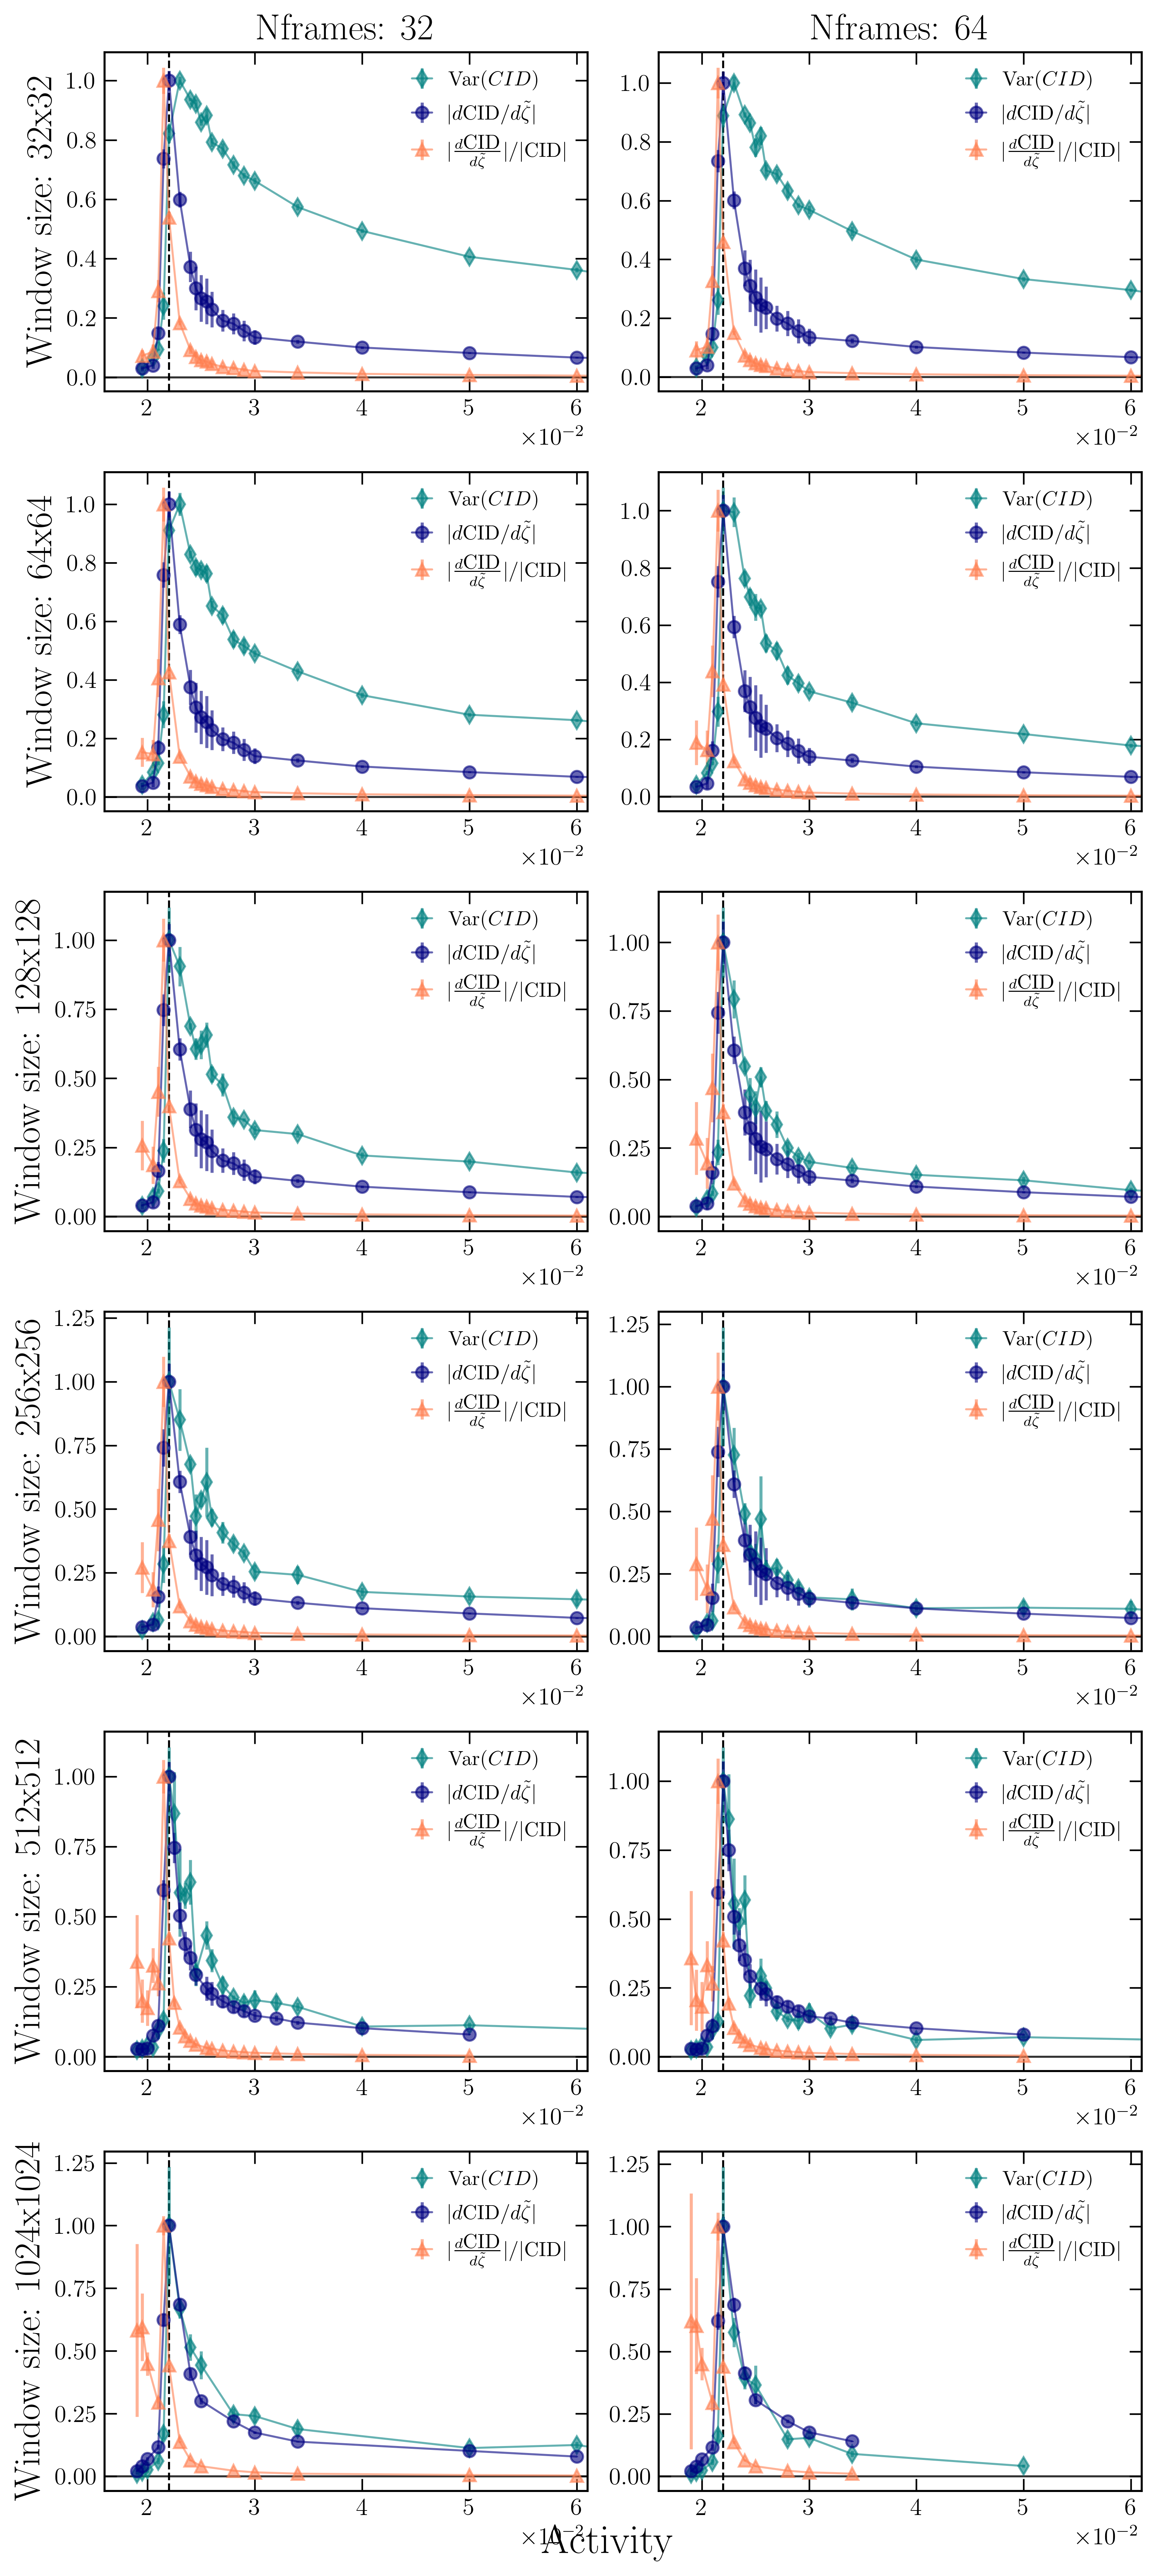

In [10]:
data_suffix='na512'
mode = 'cid'

save_fig=True
plot_abs = False
plot_var_per = False

act_exclude = 50 if data_suffix == 'abp' else None

fig_folder = fig_folder_dict[data_suffix]
figpath = f'data\\nematic\\figs\\{fig_folder}\\scaling'
if not os.path.exists(figpath):
    os.makedirs(figpath)
figpath

window_size_list = window_size_dict[data_suffix]
nsizes_list = nsizes_dict[data_suffix] 

window_size_list = [32, 64, 128, 256, 512,1024]
nsizes_list = [32, 64]

fig, ax = plt.subplots(ncols = len(nsizes_list), nrows = len(window_size_list), figsize=(4*len(nsizes_list),3*len(window_size_list)))
marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']
for j, window_size in enumerate(window_size_list):
    pass
    axx = ax[j] if len(window_size_list) > 1 else ax

    if window_size ==512: 
        data_suffix='na1024'
        nsizes_list = [32, 60]
    if window_size ==1024:
        data_suffix='na2048'
        nsizes_list = [32,64]
    cg = data_dict[data_suffix]['cg']
    LL = data_dict[data_suffix]['L_list'][0]
    ac_list = []
    for size in nsizes_list:
        cid_dict.update(data_dict[data_suffix])
        cid_dict.update({'act_exclude_dict': {256: [50]},
            'output_suffix': f'_nx{window_size}nt{size}cg{cg}' if iterate_frames else f'_nx{size}nt{nframes}cg{cg}',
        })
        cid_dict.update({'xlims': [0.016,0.061]})
        ac_tmp = AnalyseCID(cid_dict, load_data=True)
        ac_list.append(ac_tmp)

    if mode == 'cid':
        axx = plot_cid_fluctuation_scaling(LL, nsizes_list, ac_list,act_exclude=[act_exclude], cg=cid_dict['cg'], axis=axx, act_critical=cid_dict['act_critical'],
                                plot_abs=True, xlims=cid_dict['xlims'], 
                                plot_cid_per=True, 
                                plot_var_per=plot_var_per, 
                                shift_var_by_fluctuation=False,
                                zero_fluctuation_point=0,);
    elif mode == 'div':
        axx = plot_div_fluctuation_scaling(LL, nsizes_list, ac_list, cg=cid_dict['cg'], axis=axx, act_critical=cid_dict['act_critical'],
                                plot_abs=plot_abs, xlims=cid_dict['xlims'], plot_div_per=False,
                            );
    # remove titles, xlabels
    for i, a in enumerate(axx):
        if j == 0:
            a.set_title(f'Nframes: {nsizes_list[i]}')
        else:
            a.set_title('')
        a.set_xlabel('')
    for a in axx:
        a.legend(fontsize=10)
    axx[0].set_ylabel(f'Window size: {window_size}x{window_size}')
fig.supxlabel('Activity', ha='center', x=0.525,y=0.025, fontsize=20)
fig.tight_layout()
if mode == 'cid':
    savename= f'LX{LL}cid{"abs" if plot_abs else ""}_fluc_scaling_ws{min(window_size_list)}-{max(window_size_list)}.pdf'
else: 
    savename= f'LX{LL}div{"abs" if plot_abs else ""}_fluc_scaling_ws{min(window_size_list)}-{max(window_size_list)}.pdf'
savepath=os.path.join(figpath, savename)
if save_fig:
    fig.savefig(savepath, bbox_inches='tight', dpi=620, pad_inches=0.05)
    print(f"Figure saved to: {savepath}")

In [ ]:

nbits_list = [4,5,6,]
LL = 1024
cg =2
ac_list = []
for nbits in nbits_list:
    cid_dict.update({
        'nbits': nbits,
        'output_suffix': f'_nb{nbits}cg{cg}',
        'cg': cg,
    })
    ac_tmp = AnalyseCID(cid_dict, load_data=True)
    ac_list.append(ac_tmp)
#plot_cid_fluctuation_scaling(LL, nbits_list, ac_list, cg=cid_dict['cg'], act_critical=cid_dict['act_critical'], plot_abs=True, xlims=cid_dict['xlims'],
 #                          );# savepath=os.path.join(figpath, f'cid_fluctuation_scaling_cg{cg}.pdf'));#[0.016,0.035]);#None);#cid_dict['xlims']);
plot_div_fluctuation_scaling(LL, nbits_list, ac_list, cg=cid_dict['cg'], act_critical=cid_dict['act_critical'], plot_div_per=False, plot_abs=False, xlims=cid_dict['xlims'],
                           );# savepath=os.path.join(figpath, f'div_fluctuation_scaling_cg{cg}.pdf'));#[0.016,0.035]);#None);#cid_dict['xlims']);
plot_div_fluctuation_scaling(LL, nbits_list, ac_list, cg=cid_dict['cg'], use_min=True, act_critical=cid_dict['act_critical'], plot_div_per=False, plot_abs=False, xlims=cid_dict['xlims'],
                           );# savepath=os.path.join(figpath, f'div_fluctuation_scaling_cg{cg}.pdf'));#[0.016,0.035]);#None);#cid_dict['xlims']);

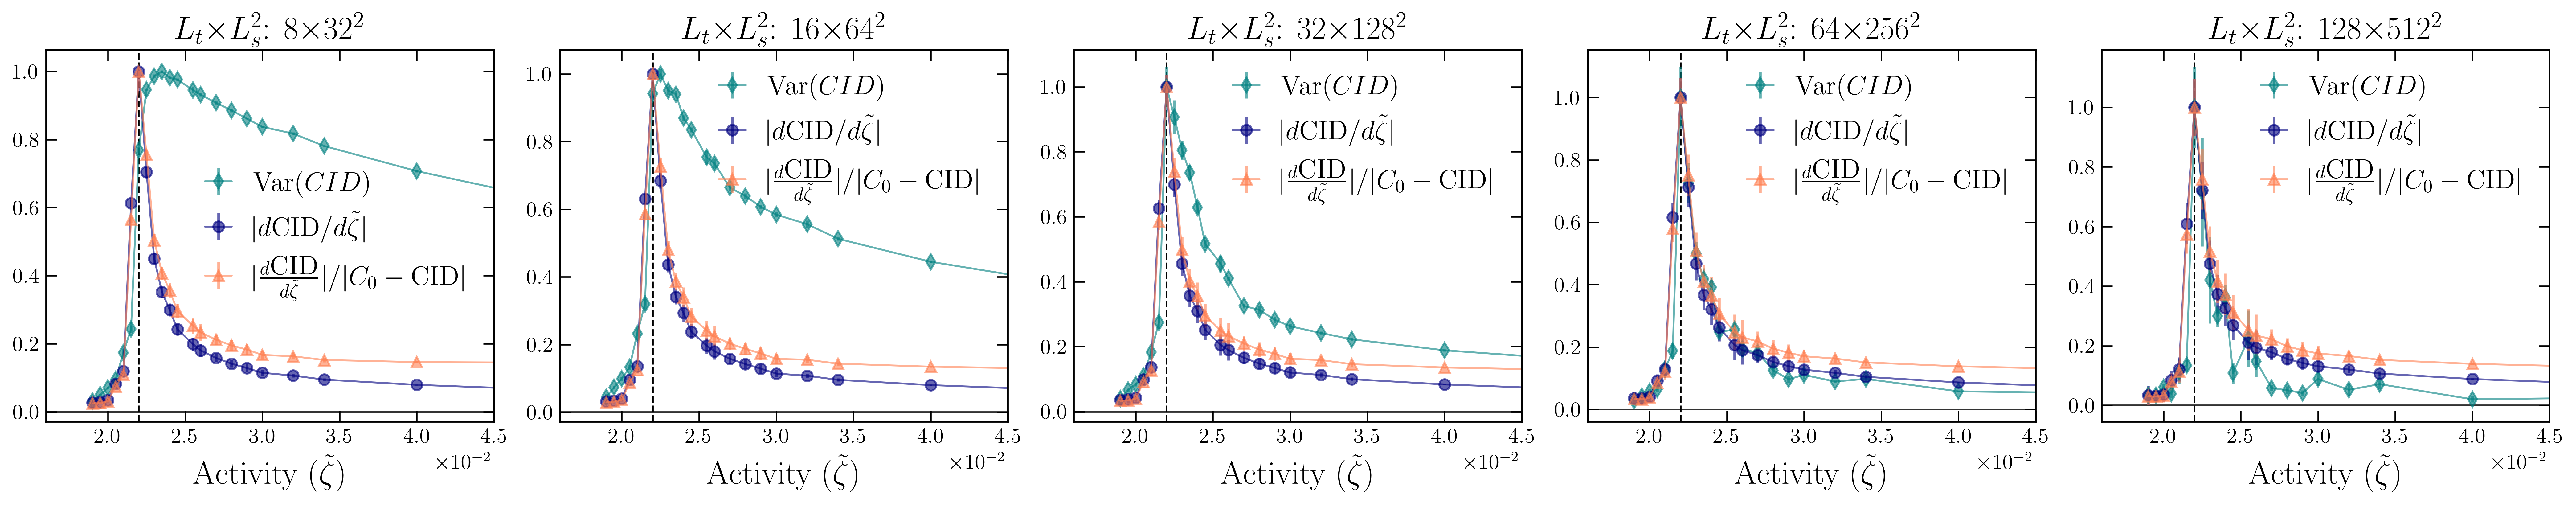

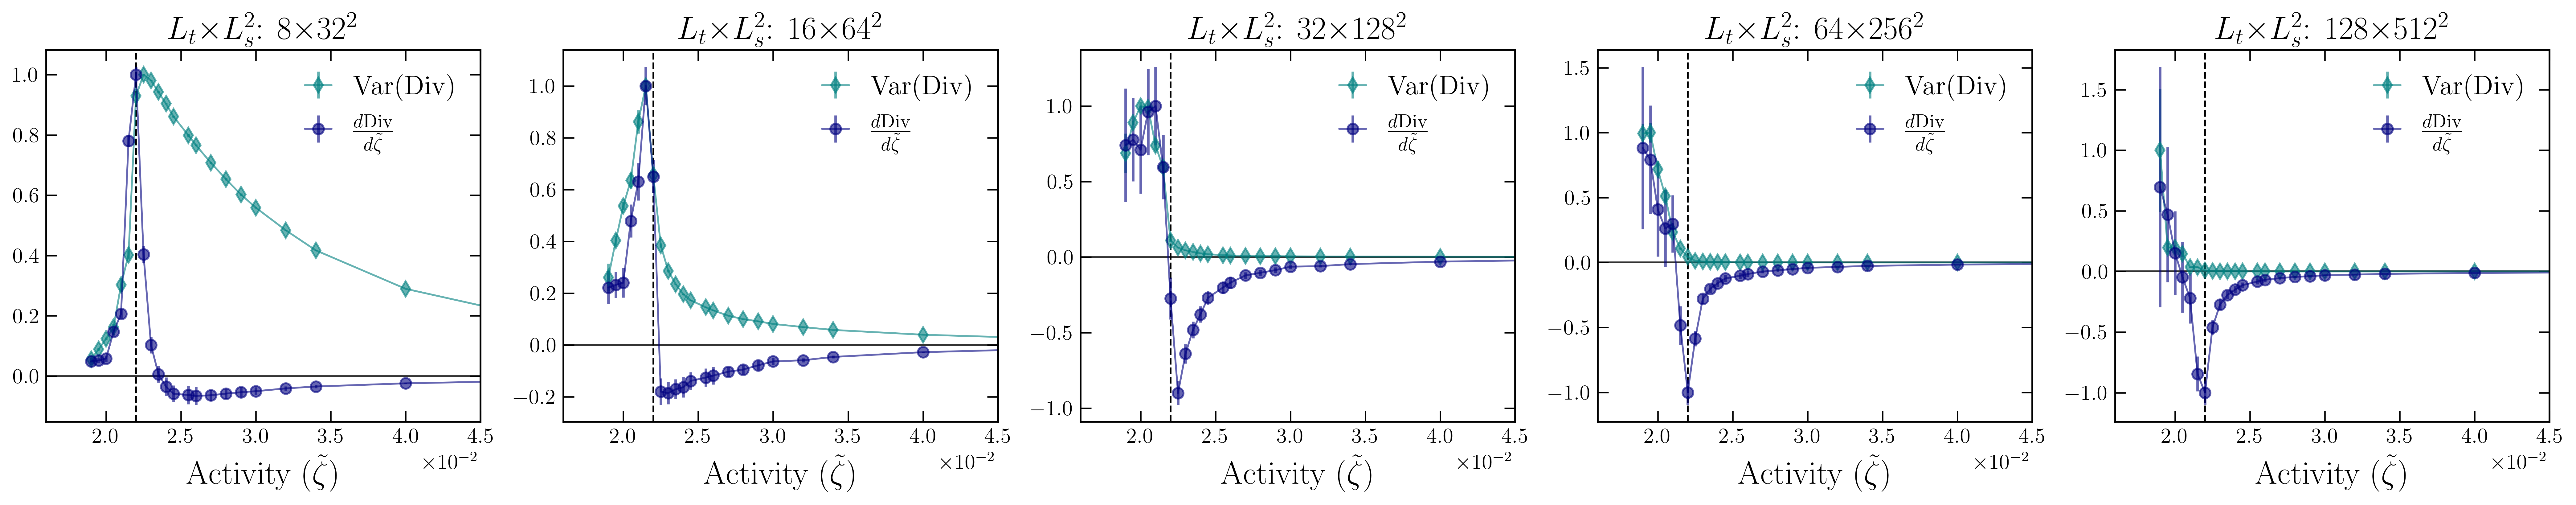

In [150]:
figpath = f'data\\nematic\\figs\\{fig_folder}\\scaling'
if not os.path.exists(figpath):
    os.makedirs(figpath)
figpath

nbits_list = [3,4,5,6,7]
LL = 1024
ac_list = []
for nbits in nbits_list:
    cid_dict.update({
        'nbits': nbits,
        'L_list': [LL],
        'Nexp_list': [5],
        'output_suffix': f'_nb{nbits}cg{cg}',
    })
    ac_tmp = AnalyseCID(cid_dict, load_data=True)
    ac_list.append(ac_tmp)


plot_cid_fluctuation_scaling(LL, nbits_list, ac_list, cg=cid_dict['cg'], act_critical=cid_dict['act_critical'],
                              plot_abs=True, xlims=cid_dict['xlims'],
                              zero_fluctuation_point=1,
                           );# savepath=os.path.join(figpath, f'cid_fluctuation_scaling_cg{cg}.pdf'));#[0.016,0.035]);#None);#cid_dict['xlims']);
plot_div_fluctuation_scaling(LL, nbits_list, ac_list, cg=cid_dict['cg'], act_critical=cid_dict['act_critical'], plot_div_per=False, plot_abs=False, xlims=cid_dict['xlims'],
                           );# savepath=os.path.join(figpath, f'div_fluctuation_scaling_cg{cg}.pdf'));#[0.016,0.035]);#None);#cid_dict['xlims']);

Thermo stuff

In [ ]:
dcid_central_dict = {}
for L in ac.L_list:
    dcid_central = calc_tangent(
        np.array(ac.act[L]),
        ac.cid_tav[L][:,0],
        ac.cid_tav[L][:,1],
    )
    dcid_central_dict[L] = dcid_central

response_zero_val = .12
fig, ax = plot_thermodynamic_efficiency(
    ac.L_list,
    ac.act,
    ac.dcid,#dcid_central_dict,
    ac.cid_tav,
    response_zero_val,
    shift_act=False,
    xlims=None, #[0, 0.05],
    plot_abs=True,)
for a in ax:
    a.vlines(0.022, 0,200, colors='red', linestyles='dashed', lw=1, alpha=0.8)